<a href="https://colab.research.google.com/github/Haythem-Jaidane/BASIRA-Lab_Internship/blob/main/Federated_learning_with_domain_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# I - Install the needed libraries

### MedMNIST : is large dataset collection of medical images. we have a library that enable us to work with.    

In [4]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=30a1b3876cc5c6e8d0a969bb58700195f7779e6c960a2a522f1cbcd6e192a434
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


# II - Import the ibraries we need in this notebbok

In [5]:
import numpy as np

import pandas as pd

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

import copy

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import metrics

from medmnist.dataset import DermaMNIST

# III - data loadding and investigation

## 1 - dataset loadding

In [6]:
!mkdir data

In [7]:
dataset_train = DermaMNIST(root='./data/', transform=transforms.ToTensor(), download=True, split='train')
dataset_test = DermaMNIST(root='./data/', transform=transforms.ToTensor(), download=True, split='test')

100%|██████████| 19725078/19725078 [00:22<00:00, 871413.28it/s] 


Using downloaded and verified file: ./data/dermamnist.npz


In [8]:
print("==============================")
print("Train Dataset description")
print("==============================")
print(dataset_train)
print("==============================")
print("Test Dataset description")
print("==============================")
print(dataset_test)

Train Dataset description
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: ./data/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Test Dataset description
Dataset DermaMNIST (dermamnist)
    Number 

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


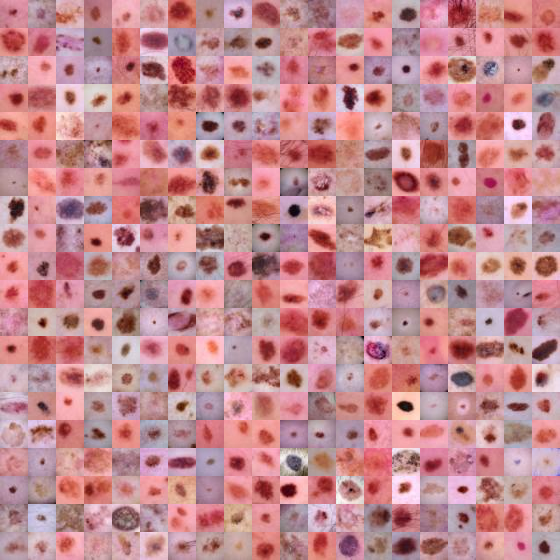

In [9]:
dataset_train.montage(length=20)

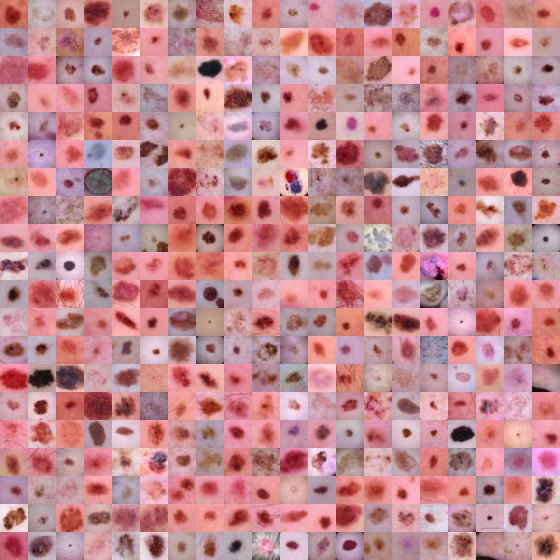

In [10]:
dataset_test.montage(length=20)

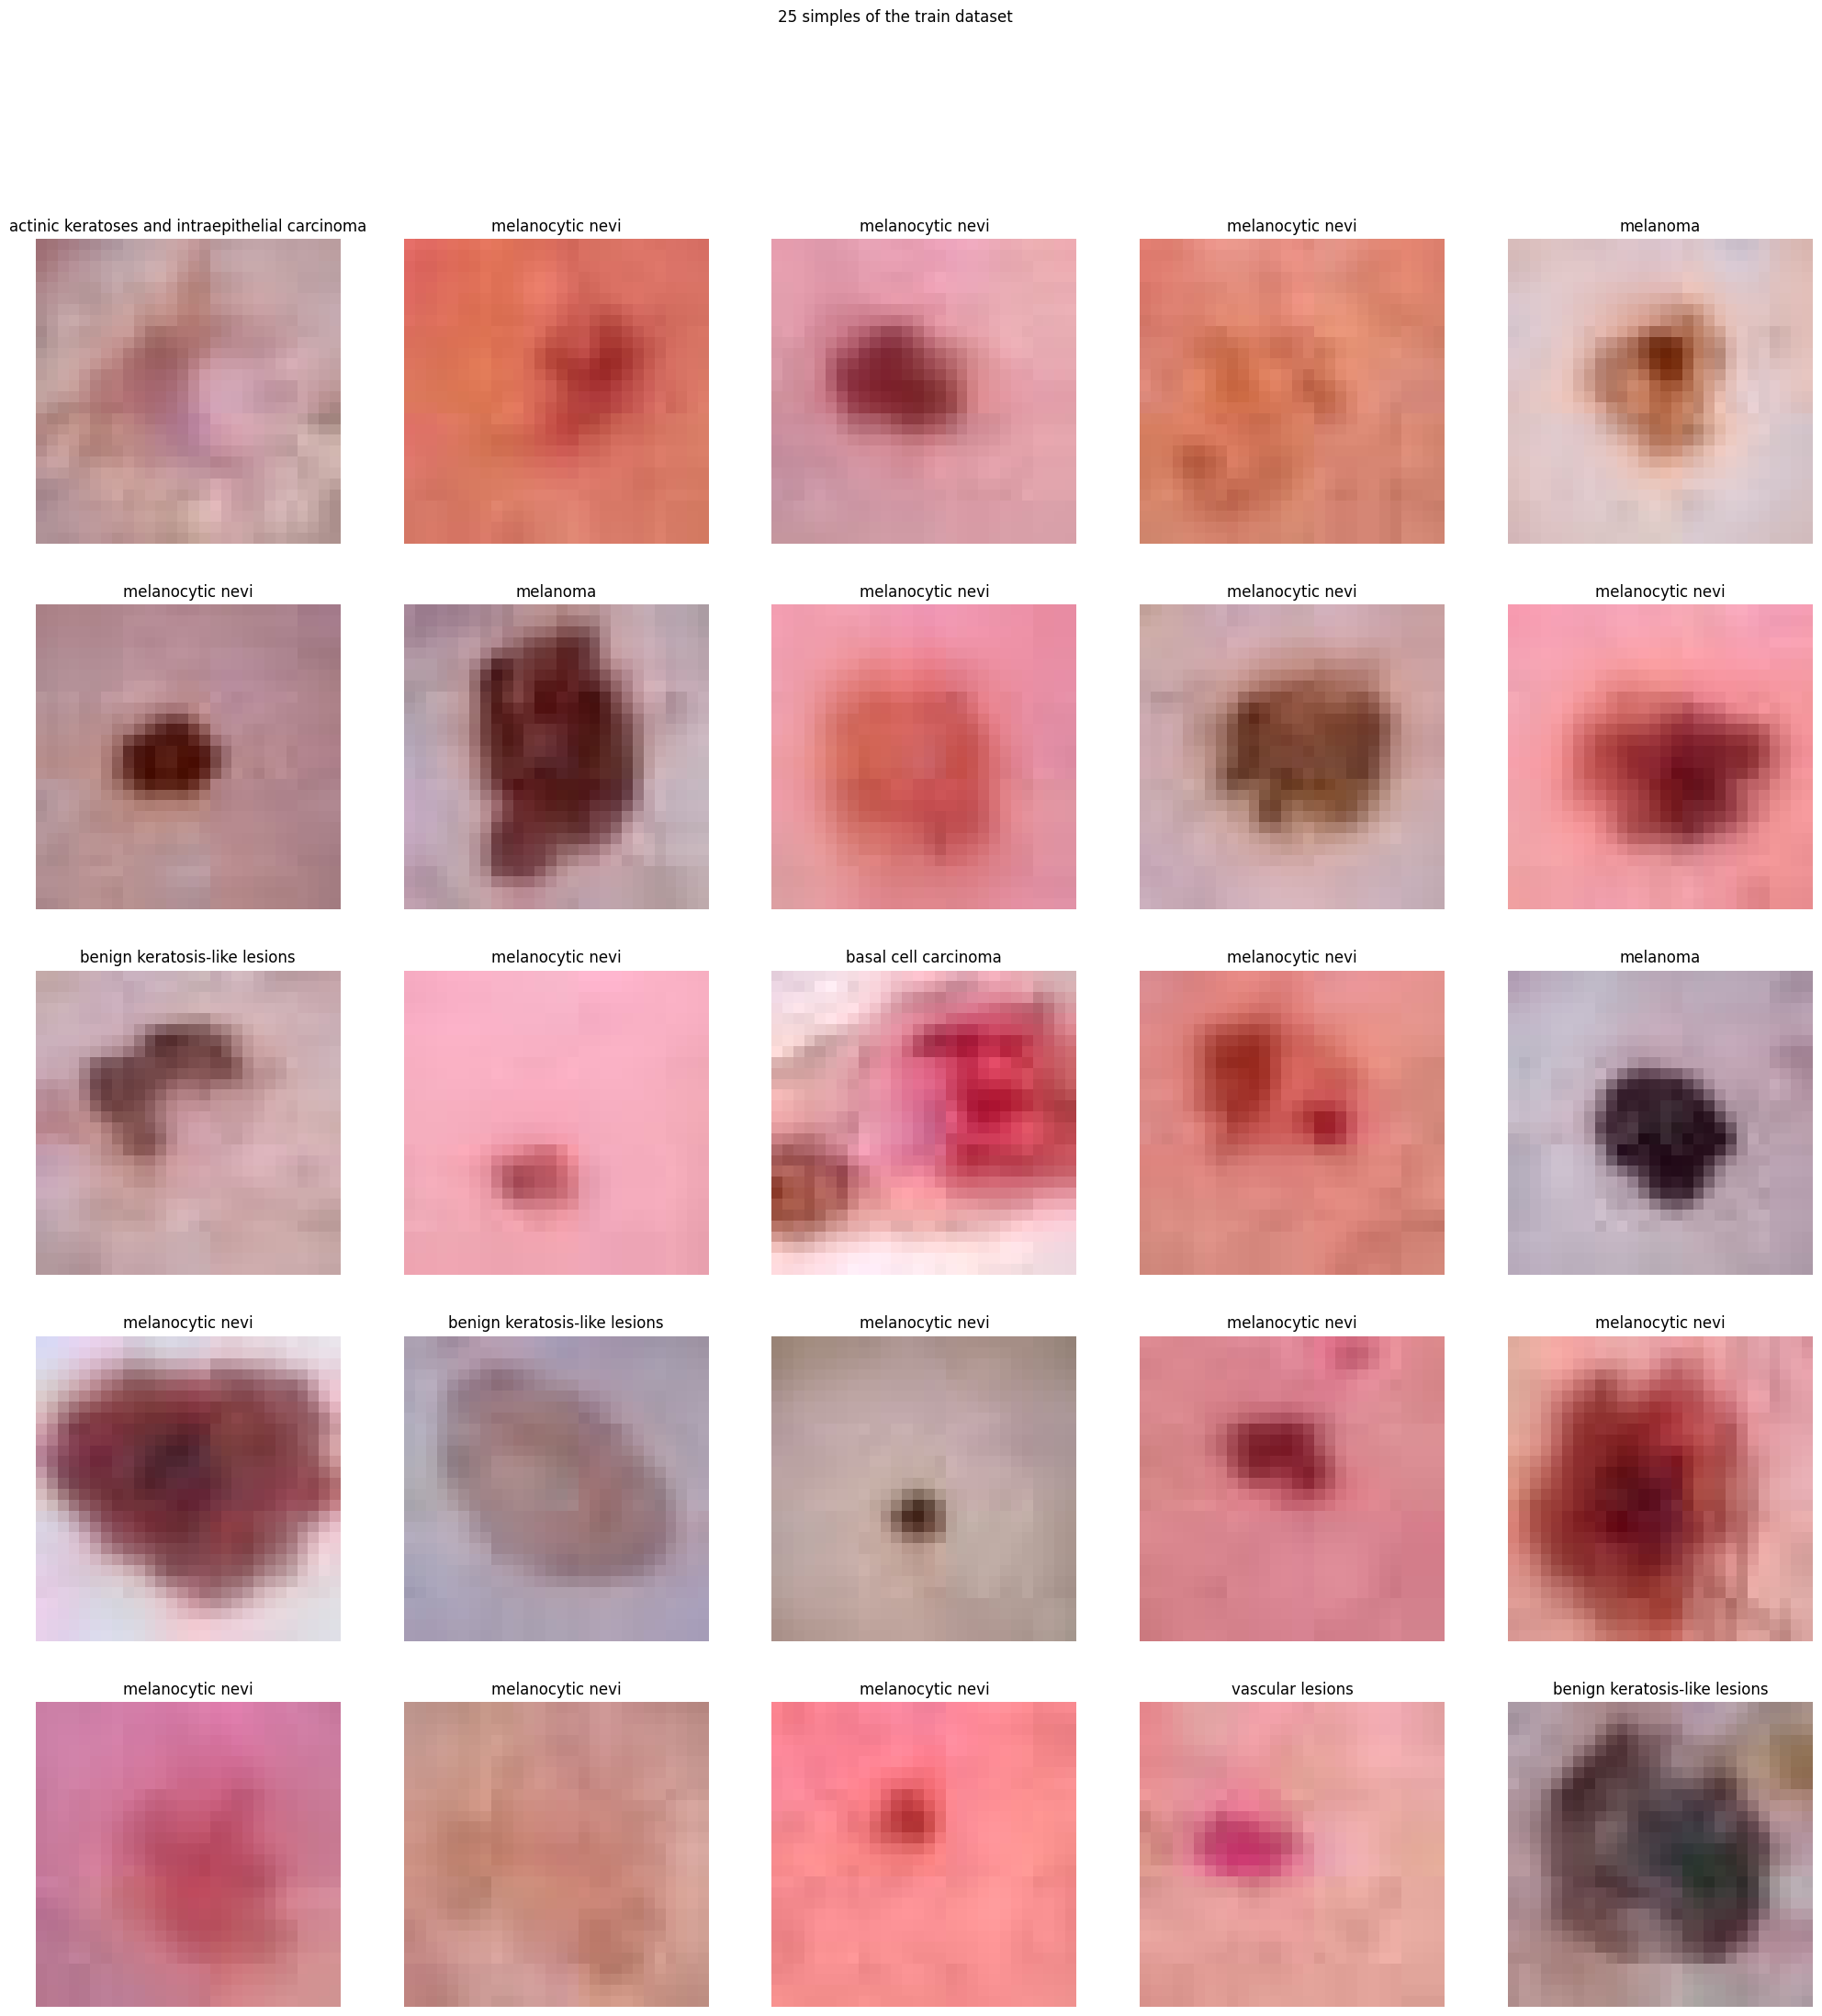

In [32]:
fig,ax = plt.subplots(5,5,figsize=(25,25))

index_simple=0

for i in range(5):
    for j in range(5):

        image = dataset_train.imgs[index_simple,:,:,:]

        class_name = ""

        if dataset_train.labels[index_simple][0] == 0:
            class_name = "actinic keratoses and intraepithelial carcinoma"
        elif dataset_train.labels[index_simple][0] == 1:
            class_name = "basal cell carcinoma"
        elif dataset_train.labels[index_simple][0] == 2:
            class_name = "benign keratosis-like lesions"
        elif dataset_train.labels[index_simple][0] == 3:
            class_name = "dermatofibroma"
        elif dataset_train.labels[index_simple][0] == 4:
            class_name = "melanoma"
        elif dataset_train.labels[index_simple][0] == 5:
            class_name = "melanocytic nevi"
        elif dataset_train.labels[index_simple][0] == 6:
            class_name = "vascular lesions"

        ax[i,j].imshow(image)
        ax[i,j].axis('off')
        ax[i,j].set_title(class_name)

        index_simple+=1

fig.suptitle("25 simples of the train dataset")
fig.show()

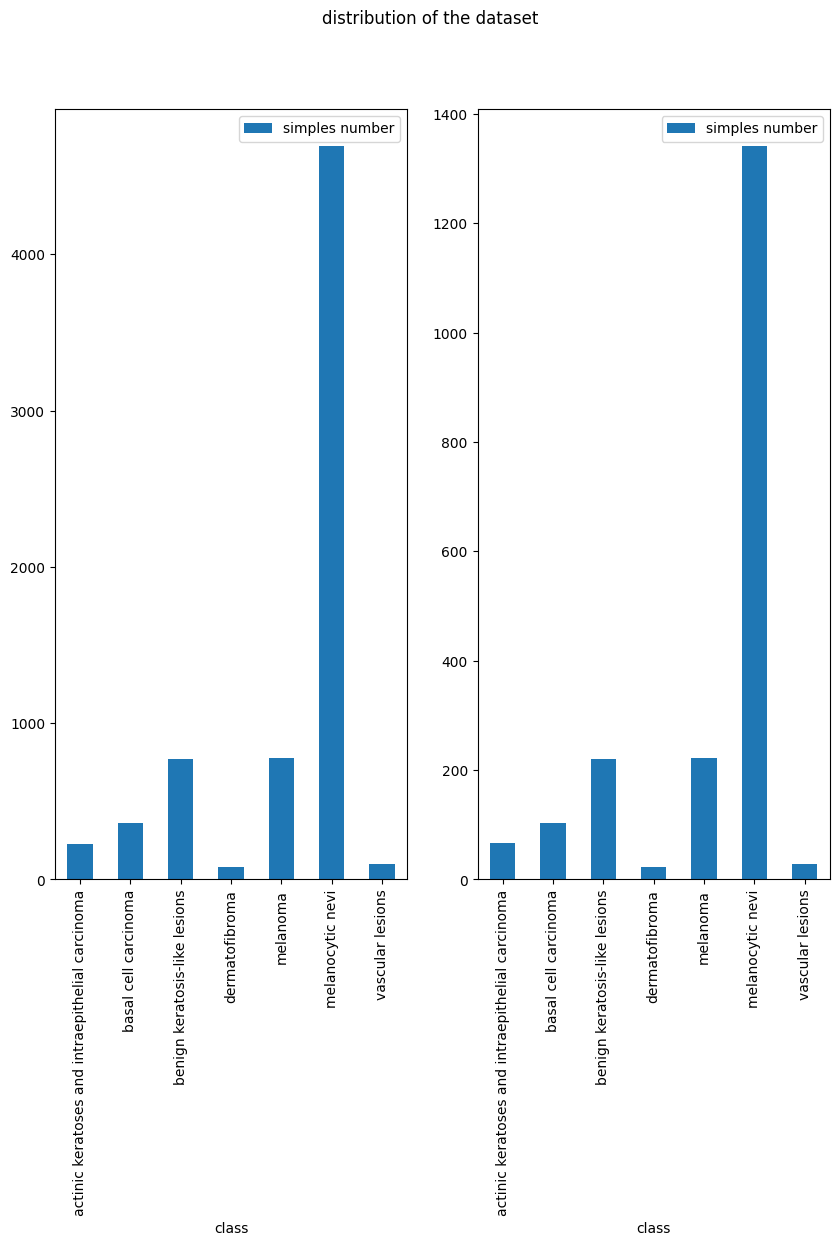

In [33]:
labels_train = {"class":["actinic keratoses and intraepithelial carcinoma","basal cell carcinoma","benign keratosis-like lesions","dermatofibroma","melanoma","melanocytic nevi","vascular lesions"],
                "simples number":[0,0,0,0,0,0,0]}

for d in dataset_train.labels:
    labels_train["simples number"][d[0]]+=1

train_distribution = pd.DataFrame(labels_train)
train_distribution.set_index('class', inplace=True)


labels_test = {"class":["actinic keratoses and intraepithelial carcinoma","basal cell carcinoma","benign keratosis-like lesions","dermatofibroma","melanoma","melanocytic nevi","vascular lesions"],
                "simples number":[0,0,0,0,0,0,0]}

for d in dataset_test.labels:
    labels_test["simples number"][d[0]]+=1

test_distribution = pd.DataFrame(labels_test)
test_distribution.set_index('class', inplace=True)

fig,ax = plt.subplots(1,2,figsize=(10,10))

train_distribution.plot.bar(ax=ax[0])
test_distribution.plot.bar(ax=ax[1])

fig.suptitle("distribution of the dataset")
fig.show()

In [34]:
X_train = dataset_train.imgs.reshape(dataset_train.imgs.shape[0], 28*28*3)
X_test = dataset_test.imgs.reshape(dataset_test.imgs.shape[0], 28*28*3)


oversampler_train = RandomOverSampler()
X_train_oversampled, y_train_oversampled = oversampler_train.fit_resample(X_train, dataset_train.labels)


oversampler_test = RandomOverSampler()
X_test_oversampled, y_test_oversampled = oversampler_test.fit_resample(X_test, dataset_test.labels)

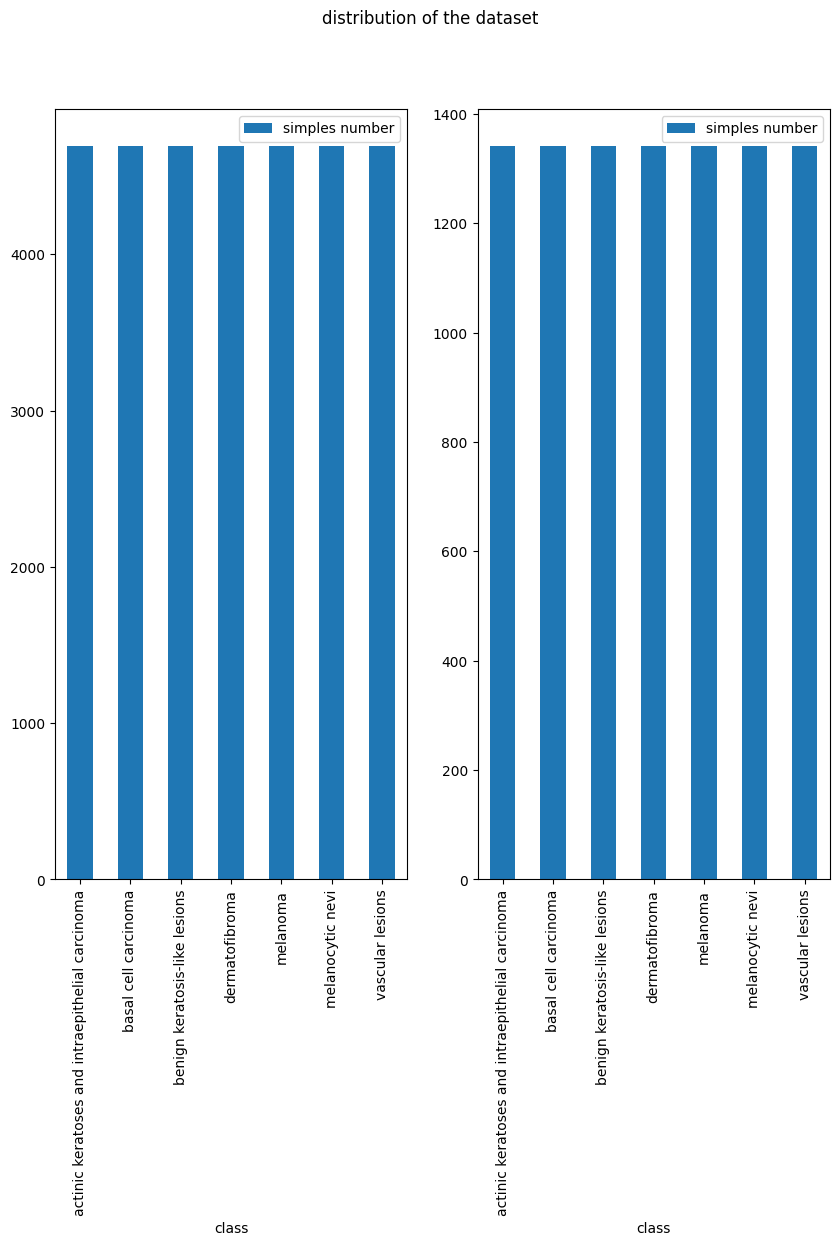

In [35]:
labels_train = {"class":["actinic keratoses and intraepithelial carcinoma","basal cell carcinoma","benign keratosis-like lesions","dermatofibroma","melanoma","melanocytic nevi","vascular lesions"],
                "simples number":[0,0,0,0,0,0,0]}

for d in y_train_oversampled:
    labels_train["simples number"][d]+=1

train_distribution = pd.DataFrame(labels_train)
train_distribution.set_index('class', inplace=True)


labels_test = {"class":["actinic keratoses and intraepithelial carcinoma","basal cell carcinoma","benign keratosis-like lesions","dermatofibroma","melanoma","melanocytic nevi","vascular lesions"],
                "simples number":[0,0,0,0,0,0,0]}

for d in y_test_oversampled:
    labels_test["simples number"][d]+=1

test_distribution = pd.DataFrame(labels_test)
test_distribution.set_index('class', inplace=True)

fig,ax = plt.subplots(1,2,figsize=(10,10))

train_distribution.plot.bar(ax=ax[0])
test_distribution.plot.bar(ax=ax[1])

fig.suptitle("distribution of the dataset")
fig.show()

In [36]:
X_train_oversampled = X_train_oversampled.reshape(X_train_oversampled.shape[0],28,28, 3)
X_test_oversampled = X_test_oversampled.reshape(X_test_oversampled.shape[0],28,28, 3)

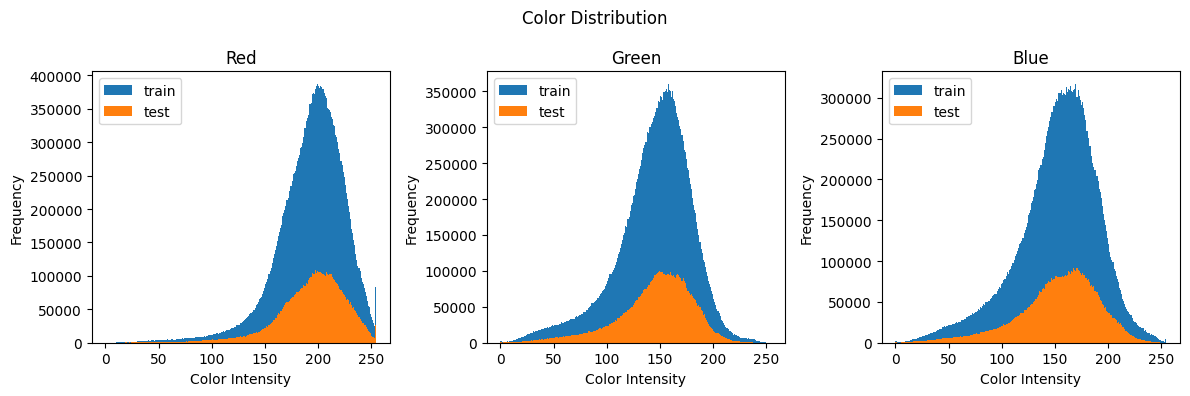

In [37]:
image_data_reshaped = X_train_oversampled.reshape(-1, 3)
image_data1_reshaped = X_test_oversampled.reshape(-1, 3)

# Calculate the color distribution
red_values = image_data_reshaped[:, 0]
green_values = image_data_reshaped[:, 1]
blue_values = image_data_reshaped[:, 2]

red_values1 = image_data1_reshaped[:, 0]
green_values1 = image_data1_reshaped[:, 1]
blue_values1 = image_data1_reshaped[:, 2]

# Plot the color distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Color Distribution')

# Red color distribution
axes[0].hist(red_values, bins=256,label="train")
axes[0].hist(red_values1, bins=256,label="test")
axes[0].legend(loc="upper left")
axes[0].set_title('Red')
axes[0].set_xlabel('Color Intensity')
axes[0].set_ylabel('Frequency')

# Green color distribution
axes[1].hist(green_values, bins=256,label="train")
axes[1].hist(green_values1, bins=256,label="test")
axes[1].legend(loc="upper left")
axes[1].set_title('Green')
axes[1].set_xlabel('Color Intensity')
axes[1].set_ylabel('Frequency')

# Blue color distribution
axes[2].hist(blue_values, bins=256,label="train")
axes[2].hist(blue_values1, bins=256,label="test")
axes[2].legend(loc="upper left")
axes[2].set_title('Blue')
axes[2].set_xlabel('Color Intensity')
axes[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [45]:
X_test_oversampled = X_test_oversampled.reshape(X_test_oversampled.shape[0],28,28,3)

test_X = X_test_oversampled.copy().astype(int)

test_X[:,:, :, 0] *= 2  # Red channel
test_X[:,:, :, 1] *= 2  # Green channel
test_X[:,:, :,2] *= 0  # Blue channel

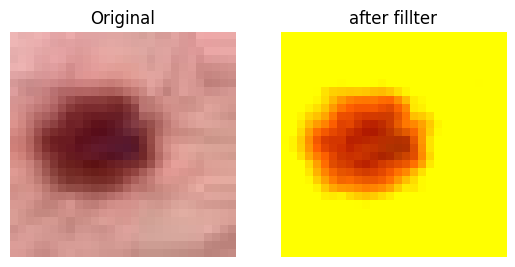

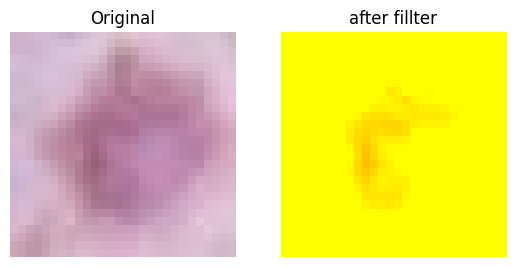

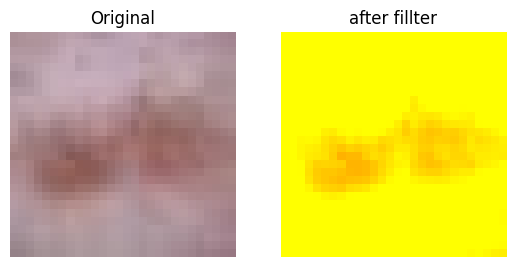

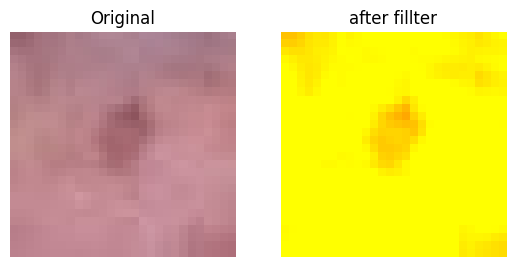

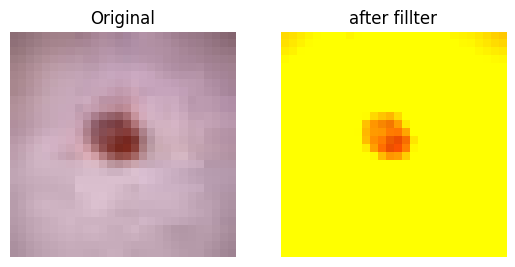

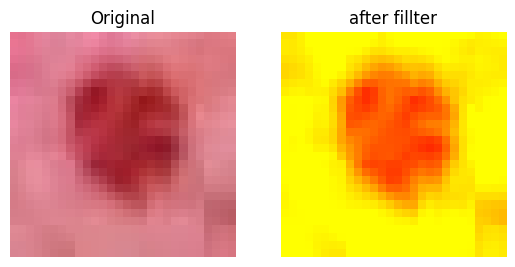

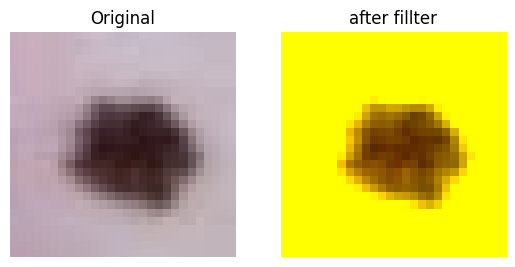

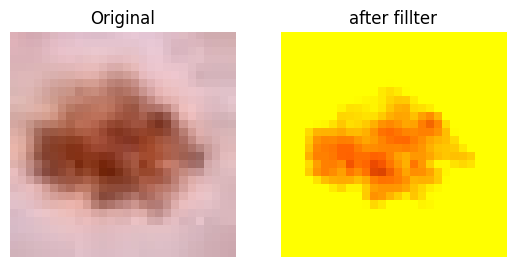

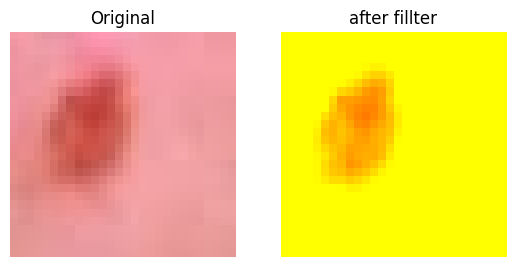

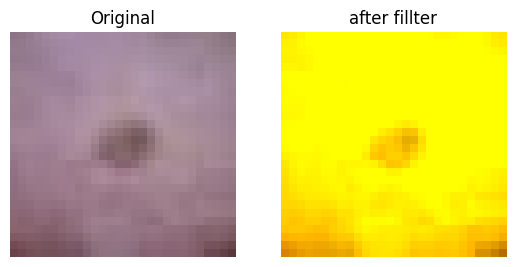

In [46]:
for i in range(10):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X_test_oversampled[i,:,:,:])
    axs[0].axis('off')
    axs[0].set_title('Original')
    axs[1].imshow(test_X[i,:,:,:])
    axs[1].axis('off')
    axs[1].set_title('after fillter')
    plt.show()

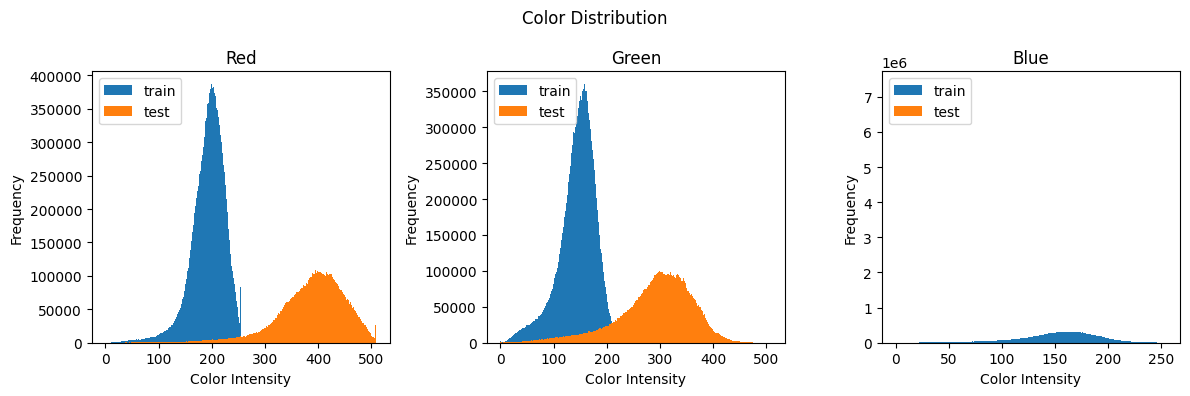

In [47]:
image_data_reshaped = X_train_oversampled.reshape(-1, 3)
image_data1_reshaped = test_X.reshape(-1, 3)

# Calculate the color distribution
red_values = image_data_reshaped[:, 0]
green_values = image_data_reshaped[:, 1]
blue_values = image_data_reshaped[:, 2]

red_values1 = image_data1_reshaped[:, 0]
green_values1 = image_data1_reshaped[:, 1]
blue_values1 = image_data1_reshaped[:, 2]

# Plot the color distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Color Distribution')

# Red color distribution
axes[0].hist(red_values, bins=256,label="train")
axes[0].hist(red_values1, bins=256,label="test")
axes[0].legend(loc="upper left")
axes[0].set_title('Red')
axes[0].set_xlabel('Color Intensity')
axes[0].set_ylabel('Frequency')

# Green color distribution
axes[1].hist(green_values, bins=256,label="train")
axes[1].hist(green_values1, bins=256,label="test")
axes[1].legend(loc="upper left")
axes[1].set_title('Green')
axes[1].set_xlabel('Color Intensity')
axes[1].set_ylabel('Frequency')

# Blue color distribution
axes[2].hist(blue_values, bins=256,label="train")
axes[2].hist(blue_values1, bins=256,label="test")
axes[2].legend(loc="upper left")
axes[2].set_title('Blue')
axes[2].set_xlabel('Color Intensity')
axes[2].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

# IV - Model definition

In [19]:
class CNN(nn.Module):

    def __init__(self,num_class):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_class))


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [20]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = torchvision.models.resnet50()
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [21]:
class ResNet50_pretrainied(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# V - training Models

## 1 - object definition

In [51]:
class fitting():
    def __init__(self, num_fold=4, training_type=0, num_class=7, ModelType=CNN, img_train=X_train_oversampled, labels_train=y_train_oversampled,img_test=X_test_oversampled, labels_test=y_test_oversampled, optimizer=optim.SGD):
        self.KFold = StratifiedKFold(n_splits=num_fold, shuffle=True)
        self.num_class = num_class
        self.model = ModelType
        self.img_train = img_train.reshape(img_train.shape[0], 28, 28, 3)
        self.labels_train = labels_train
        self.img_test = img_test.reshape(img_test.shape[0], 28, 28, 3)
        self.labels_test = labels_test
        self.Optimizer = optimizer
        if training_type == 1:
            self.num_client = num_fold

    def train(self, epoch_num, batch_size, lr):
        models_list = []
        acc = []
        loss_train = []
        loss_validation = []
        test_results = [[],[]]
        for fold, (train_index, val_index) in enumerate(self.KFold.split(self.img_train, self.labels_train)):
            print(f"Fold {fold+1}:")
            loss_train_f = []
            loss_validation_f = []

            X_train, X_val = self.img_train[train_index], self.img_train[val_index]
            y_train, y_val = self.labels_train[train_index], self.labels_train[val_index]

            model = self.model(self.num_class)

            criterion = nn.CrossEntropyLoss()
            optimizer = self.Optimizer(model.parameters(), lr=lr, weight_decay=0.0001)

            train_dataset = data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
            val_dataset = data.TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

            train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = data.DataLoader(val_dataset)

            for epoch in range(epoch_num):
                model.train()
                for batch, (X_, y_) in enumerate(train_loader):
                    optimizer.zero_grad()
                    outputs = model(X_.permute(0, 3, 1, 2))  # Transpose the channels to match the model's input shape
                    loss = criterion(outputs, y_)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    correct = 0
                    total = 0
                    for val_batch_X, val_batch_y in val_loader:
                        val_batch_X = val_batch_X.permute(0, 3, 1, 2)  # Transpose the channels
                        val_outputs = model(val_batch_X)
                        _, predicted = torch.max(val_outputs.data, 1)
                        total += val_batch_y.size(0)
                        correct += (predicted == val_batch_y).sum().item()
                        val_loss += criterion(val_outputs, val_batch_y).item()

                    val_accuracy = 100 * correct / total
                    avg_val_loss = val_loss / len(val_loader)

                # Print metrics for each epoch
                print(f"Epoch {epoch+1}:")
                print(f"Train Loss: {loss.item():.4f}")
                print(f"Validation Loss: {avg_val_loss:.4f}")
                print(f"Validation Accuracy: {val_accuracy:.2f}%")

                acc_list,sens_list,spec_list = self.test([model])
                print(f"Test Accuracy: {acc_list[0]:.2f}%")
                print()

                loss_train_f.append(loss.item())
                loss_validation_f.append(avg_val_loss)
                test_results[fold].append(acc_list)

            loss_train.append(loss_train_f)
            loss_validation.append(loss_validation_f)

            models_list.append(model)
            acc.append(val_accuracy)

        return models_list, acc, loss_train, loss_validation,test_results

    def train_federated(self,lr,epoch_num,periode_num,algo):


        server_model = self.model(self.num_class)
        models_list_federated = [copy.deepcopy(server_model) for _ in range(self.num_client)]
        models_list_non_federated = [copy.deepcopy(server_model) for _ in range(self.num_client)]
        acc = [[],[],[],[],[],[],[],[],[]]
        loss_train = [[],[],[],[],[],[],[],[],[]]
        loss_test = [[],[],[],[],[],[],[],[],[]]

        optimizers_federated = [self.Optimizer(models_list_federated[i].parameters(), lr=lr,weight_decay=0.0001) for i in range(self.num_client)]
        optimizers_non_federated = [self.Optimizer(models_list_non_federated[i].parameters(), lr=lr,weight_decay=0.0001) for i in range(self.num_client)]

        test_results =[]

        fold_data = []

        for train_index, val_index in self.KFold.split(self.img_train, self.labels_train):
            X_train, X_val = self.img_train[train_index], self.img_train[val_index]
            y_train, y_val = self.labels_train[train_index], self.labels_train[val_index]

            train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float().clone().detach(), torch.tensor(y_train).long().clone().detach())
            val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val).float().clone().detach(), torch.tensor(y_val).long().clone().detach())

            fold_data.append({'train': train_dataset, 'val': val_dataset})

        for periode in range(periode_num):
            print(f"round {periode+1} : ")
            for fold in range(len(fold_data)):


                print(f"Client {fold+1} : ")
                model = models_list_federated[fold]
                model_alone = models_list_non_federated[fold]

                criterion = nn.CrossEntropyLoss()
                optimizer = optimizers_federated[fold]
                criterion1 = nn.CrossEntropyLoss()
                optimizer1 = optimizers_non_federated[fold]
                train_loader = data.DataLoader(fold_data[fold]['train'], batch_size=128, shuffle=True)
                val_loader = data.DataLoader(fold_data[fold]['val'])

                for epoch in range(epoch_num):

                    model.train()
                    model_alone.train()


                    for batch, (X_, y_) in enumerate(train_loader):
                        X_ = X_.view(-1, 3, 28, 28)
                        y_ = y_.squeeze().long()

                        optimizer.zero_grad()
                        optimizer1.zero_grad()


                        outputs = model(X_)
                        outputs1 = model_alone(X_)


                        loss = criterion(outputs, y_)
                        loss1 = criterion1(outputs1, y_)


                        loss.backward()
                        loss1.backward()


                        optimizer.step()
                        optimizer1.step()

                    model.eval()
                    model_alone.eval()
                    with torch.no_grad():
                        val_loss = 0.0
                        correct = 0
                        total = 0
                        val_loss1 = 0.0
                        correct1 = 0
                        for val_batch_X, val_batch_y in val_loader:
                            val_batch_X = val_batch_X.view(-1, 3, 28, 28)
                            val_outputs = model(val_batch_X)
                            val_outputs1 = model_alone(val_batch_X)
                            _, predicted = torch.max(val_outputs.data, 1)
                            _, predicted1 = torch.max(val_outputs1.data, 1)
                            total += val_batch_y.size(0)
                            correct += (predicted == val_batch_y).sum().item()
                            correct1 += (predicted1 == val_batch_y).sum().item()
                            val_loss += criterion(val_outputs, val_batch_y).item()
                            val_loss1 += criterion1(val_outputs1, val_batch_y).item()

            # Calculate accuracy and average loss for validation
                        val_accuracy = 100 * correct / total
                        avg_val_loss = val_loss / len(val_loader)

                        val_accuracy1 = 100 * correct1 / total
                        avg_val_loss1 = val_loss1 / len(val_loader)

                    acc[fold].append(val_accuracy)
                    loss_train[fold].append(loss.item())
                    loss_test[fold].append(val_accuracy)

                    acc[fold+self.num_client].append(val_accuracy1)
                    loss_train[fold+self.num_client].append(loss1.item())
                    loss_test[fold+self.num_client].append(val_accuracy1)

                    models_list_federated[fold] = model
                    models_list_non_federated[fold] = model_alone

                    optimizers_federated[fold] = optimizer
                    optimizers_non_federated[fold] = optimizer1

        # Print metrics for each epoch
                    print(f"Epoch {epoch+1}:")
                    print(f"Train Loss: {loss.item():.4f}")
                    print(f"Validation Loss: {avg_val_loss:.4f}")
                    print(f"Validation Accuracy: {val_accuracy:.2f}%")
                    print("------------------------------------")
                    print(f"Train Loss (alone): {loss1.item():.4f}")
                    print(f"Validation Loss (alone): {avg_val_loss1:.4f}")
                    print(f"Validation Accuracy (alone): {val_accuracy1:.2f}%")
                    print()
                    t = self.test(models_list_federated)
                    t1 = self.test([server_model])
                    t2 = self.test(models_list_non_federated)
                    test_results.append(t)
                    print("server acc : ",t1[0])
                    print()
                    print("Hospital 1 : federated : ",t[0][0]," non federated : ",t2[0][0])
                    print("Hospital 2 : federated : ",t[0][1]," non federated : ",t2[0][1])

                    print()


          #acc.append(val_accuracy)

            if algo=="FedAVG":
                for key in server_model.state_dict().keys():
                    if 'num_batches_tracked' in key:
                        server_model.state_dict()[key].data.copy_(models_list_federated[1].state_dict()[key])
                    else:
                        temp = torch.zeros_like(server_model.state_dict()[key])
                        for client_idx in range(self.num_client):
                            temp += (1/self.num_client) * models_list_federated[client_idx].state_dict()[key]
                        server_model.state_dict()[key].data.copy_(temp)
                        for client_idx in range(self.num_client):
                            models_list_federated[client_idx].state_dict()[key].data.copy_(server_model.state_dict()[key])
            elif algo=="FedALA":
                pass
            elif algo=="FedBN":
                pass




        return models_list_federated,models_list_non_federated,acc,loss_train,loss_test,test_results

    def test(self,model_list):

        test_loader = data.DataLoader(data.TensorDataset(torch.tensor(self.img_test).float(), torch.tensor(self.labels_test).long()))

        acc_list = []
        spec_list = []
        sens_list = []

        for m in model_list:
            correct , total = 0,0
            prediction = []

            true_negatives = [0] * 7
            total_negatives = [0] * 7
            class_correct = [0] * 7
            class_total = [0] * 7

            m.eval()

            spec = [0] * 7
            sens = [0] * 7

            predicted_list = []

            for img, labels in test_loader:

                img = img.permute(0, 3, 1, 2)

                output = m(img)
                _, predicted = torch.max(output.data, 1)

                predicted_list.append(predicted.long().detach().numpy())

            predicted_list = np.array(predicted_list).reshape(len(predicted_list))
            target = torch.tensor(self.labels_test).long().detach().numpy()


            accuracy = metrics.accuracy_score(target, predicted_list)
            precision = metrics.precision_score(target, predicted_list, average='weighted')
            recall = metrics.recall_score(target, predicted_list, average='weighted')
            f1_score = metrics.f1_score(target, predicted_list, average='weighted')

            spec_list.append(precision*100)
            acc_list.append(accuracy*100)
            sens_list.append(recall*100)

        return acc_list,sens_list,spec_list



In [ ]:
CNN_baseline = fitting(num_fold=2)
ResNet50_baseline = fitting(num_fold=2, ModelType=ResNet50,optimizer=optim.Adam)

CNN_federated = fitting(num_fold=2,training_type=1)
ResNet50_federated = fitting(num_fold=2, ModelType=ResNet50,optimizer=optim.Adam,training_type=1)

CNN_federated_shifted = fitting(num_fold=2,training_type=1,img_test=test_X)
ResNet50_federated_shifted = fitting(num_fold=2, ModelType=ResNet50,optimizer=optim.Adam,training_type=1,img_test=test_X)

models_list_ResNet50_baseline, acc_ResNet50_baseline, loss_train_ResNet50_baseline, loss_validation_ResNet50_baseline,test_RestNet50 = ResNet50_baseline.train(5,128,1e-5)
models_list_cnn_baseline, acc_cnn_baseline, loss_train_cnn_baseline, loss_validation_cnn_baseline,test_CNN = CNN_baseline.train(5,128,1e-5)

models_list_cnn_fedAVG_fed,models_list_cnn_fedAVG,acc_cnn_fedAVG,loss_train_cnn_fedAVG,loss_test_cnn_fedAVG,test_results_cnn_fedAVG = CNN_federated.train_federated(1e-5,1,5,"FedAVG")
models_list_ResNet50_fedAVG_fed,models_list_ResNet50_fedAVG,acc_ResNet50_fedAVG,loss_train_ResNet50_fedAVG,loss_test_ResNet50_fedAVG,test_results_ResNet50_fedAVG = ResNet50_federated.train_federated(1e-5,1,5,"FedAVG")

models_list_cnn_fedAVG_shift_fed,models_list_cnn_fedAVG_shift,acc_cnn_fedAVG_shift,loss_train_cnn_fedAVG_shift,loss_test_cnn_fedAVG_shift,test_results_cnn_fedAVG_shift  = CNN_federated_shifted.train_federated(1e-5,1,5,"FedAVG")
models_list_ResNet50_fedAVG_shift_fed,models_list_ResNet50_fedAVG_shift,acc_ResNet50_fedAVG_shift,loss_train_ResNet50_fedAVG_shift,loss_test_ResNet50_fedAVG_shift,test_results_ResNet50_fedAVG_shift  = ResNet50_federated_shifted.train_federated(1e-5,1,5,"FedAVG")


Fold 1:
Epoch 1:
Train Loss: 1.9847
Validation Loss: 1.9534
Validation Accuracy: 14.09%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.66%

Epoch 2:
Train Loss: 1.9505
Validation Loss: 1.9530
Validation Accuracy: 14.31%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.10%

Epoch 3:
Train Loss: 1.9921
Validation Loss: 1.9525
Validation Accuracy: 14.10%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.09%

Epoch 4:
Train Loss: 1.9421
Validation Loss: 1.9521
Validation Accuracy: 14.19%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.61%

Epoch 5:
Train Loss: 1.9632
Validation Loss: 1.9518
Validation Accuracy: 14.26%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.39%

Fold 2:
Epoch 1:
Train Loss: 1.9445
Validation Loss: 1.9578
Validation Accuracy: 14.27%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 12.76%

Epoch 2:
Train Loss: 1.9422
Validation Loss: 1.9573
Validation Accuracy: 14.31%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.73%

Epoch 3:
Train Loss: 1.9559
Validation Loss: 1.9566
Validation Accuracy: 14.27%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 14.09%

Epoch 4:
Train Loss: 1.9733
Validation Loss: 1.9564
Validation Accuracy: 14.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 12.80%

Epoch 5:
Train Loss: 1.9548
Validation Loss: 1.9554
Validation Accuracy: 14.31%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 13.93%

round 1 : 
Client 1 : 
Epoch 1:
Train Loss: 1.9323
Validation Loss: 1.9487
Validation Accuracy: 12.91%
------------------------------------
Train Loss (alone): 1.9323
Validation Loss (alone): 1.9487
Validation Accuracy (alone): 12.91%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

server acc :  [15.457547672312774]

Hospital 1 : federated :  13.028656652817727  non federated :  13.028656652817727
Hospital 2 : federated :  15.457547672312774  non federated :  15.457547672312774

Client 2 : 
Epoch 1:
Train Loss: 1.9585
Validation Loss: 1.9482
Validation Accuracy: 12.70%
------------------------------------
Train Loss (alone): 1.9585
Validation Loss (alone): 1.9482
Validation Accuracy (alone): 12.70%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

server acc :  [15.457547672312774]

Hospital 1 : federated :  13.028656652817727  non federated :  13.028656652817727
Hospital 2 : federated :  12.187067220624268  non federated :  12.187067220624268

round 2 : 
Client 1 : 
Epoch 1:
Train Loss: 1.9403
Validation Loss: 1.9480
Validation Accuracy: 13.13%
------------------------------------
Train Loss (alone): 1.9403
Validation Loss (alone): 1.9480
Validation Accuracy (alone): 13.13%



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

server acc :  [12.38947480558219]

Hospital 1 : federated :  12.38947480558219  non federated :  12.38947480558219
Hospital 2 : federated :  12.38947480558219  non federated :  12.187067220624268

Client 2 : 


# VI - Plot results

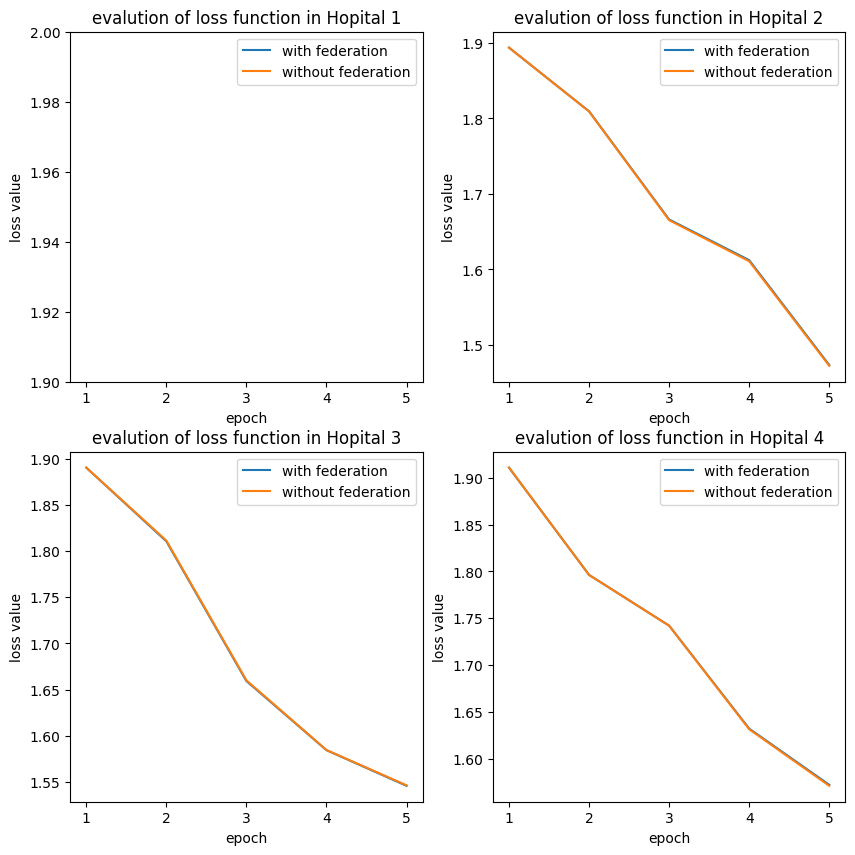

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
t = np.arange(1, 6, 1)


ax[0].plot(t, loss_train_cnn_fedAVG[0],label="with federation")
ax[0].plot(t, loss_train_cnn_fedAVG[2],label="without federation")
ax[0].legend(loc="upper right")
ax[0].set(xlabel='epoch', ylabel='loss value',title='evalution of loss function in Hopital 1')

ax[1].plot(t, loss_train_cnn_fedAVG[1],label="with federation")
ax[1].plot(t, loss_train_cnn_fedAVG[3],label="without federation")
ax[1].legend(loc="upper right")
ax[1].set(xlabel='epoch', ylabel='loss value',title='evalution of loss function in Hopital 2')


plt.show()

In [ ]:
acc_list,sens_list,spec_list =CNN_federated.test(models_list_cnn_fedAVG_fed)
acc_list1,sens_list1,spec_list1 =CNN_federated.test(models_list_cnn_fedAVG)

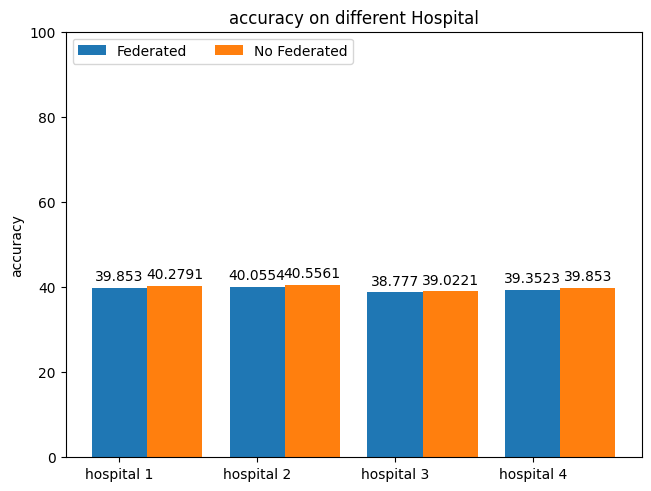

In [ ]:
x = np.arange(4)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (acc_list[0]),
    'No Federated': (acc_list1[0]),
}

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('accuracy on different Hospital')
ax.set_xticks(x + width, ("hospital 1","hospital 2","hospital 3","hospital 4"))
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

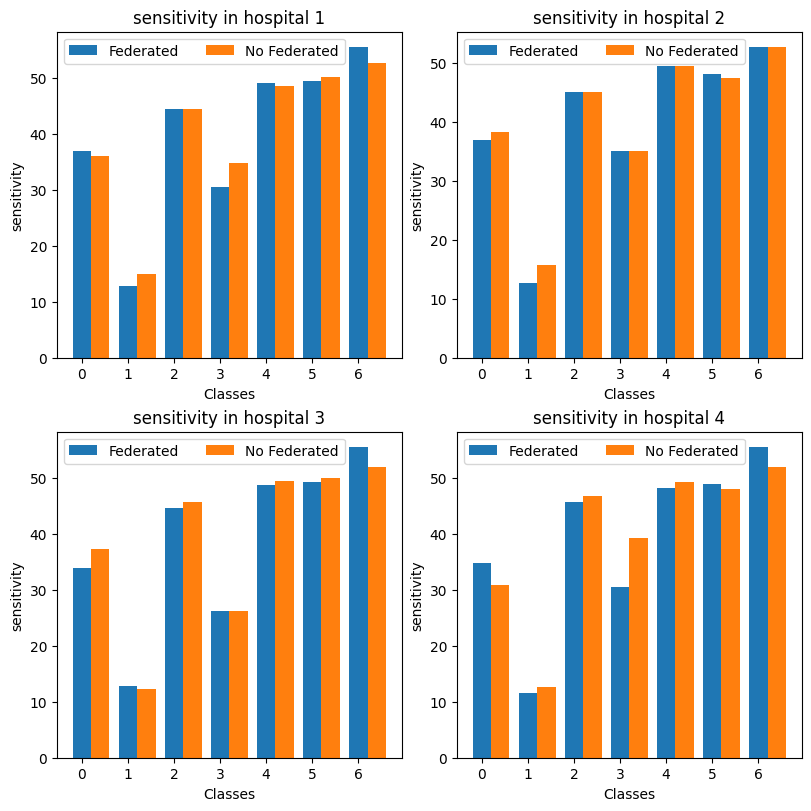

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (sens_list[0], sens_list[1]),
    'No Federated': (sens_list1[0], sens_list1[1]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0,0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0,0].legend(loc='upper left', ncols=3)
    ax[0,0].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 1')

    ax[0,1].bar(x+offset,measurement[1], width, label=attribute)
    ax[0,1].set(xlabel='Classes', ylabel='sensitivity',title='sensitivity in hospital 2')
    ax[0,1].legend(loc='upper left', ncols=3)


    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.


plt.show()

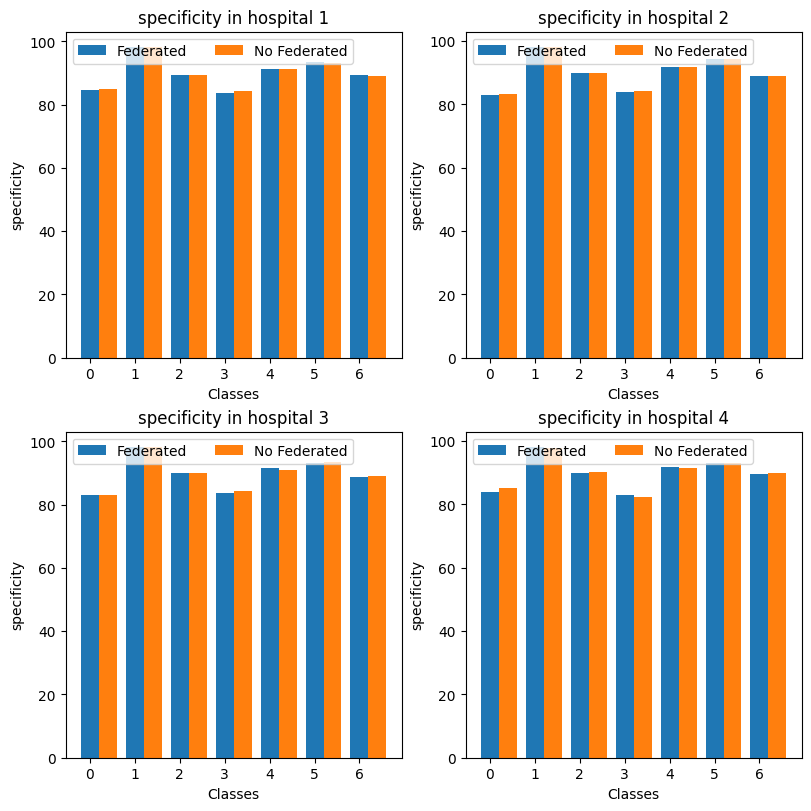

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,8),layout='constrained')



x = np.arange(7)  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

penguin_means = {
    'Federated': (spec_list[0], spec_list[1],spec_list[2], spec_list[3]),
    'No Federated': (spec_list[4], spec_list[5],spec_list[6], spec_list[7]),
}

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    ax[0,0].bar(x+offset,measurement[0], width, label=attribute)
    ax[0,0].legend(loc='upper left', ncols=3)
    ax[0,0].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 1')

    ax[0,1].bar(x+offset,measurement[1], width, label=attribute)
    ax[0,1].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 2')
    ax[0,1].legend(loc='upper left', ncols=3)

    ax[1,0].bar(x+offset,measurement[2], width, label=attribute)
    ax[1,0].set(xlabel='Classes', ylabel='specificity',title='specificity in hospital 3')
    ax[1,0].legend(loc='upper left', ncols=3)

    ax[1,1].bar(x+offset,measurement[3], width, label=attribute)
    ax[1,1].set(xlabel='Classes',ylabel='specificity',title='specificity in hospital 4')
    ax[1,1].legend(loc='upper left', ncols=3)


    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.


plt.show()